# Efficient Data Stream Anomaly Detection

Python script capable of detecting anomalies in a continuous data stream. This stream, simulating real-time sequences of floating numbers, could represent various metrics such as financial transaction or system metrics. Focus will be on identifying unusual patterns, such as exceptionally high values or deviation from the norm.

## Git command

In [1]:
#init git everytime running script
#!git init 

#connect to remote github repository using url
#!git remote add origin https://github.com/haziq2010443/Data-Stream-Anomaly-Detection.git

#commit changes with message
#!git commit -m "Try First Commit with Jupyter Notebook"

#push changes to remote repository on master branch
#!git push -u origin master

#pull recent changes to jupyter notebook
#!git pull

## Import Necessary Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

## Simulating a Real-Time Data Stream

### Function to Simulate Data Stream

This function generates a multivariate data stream with regular patterns, seasonal elements, & random noises

In [9]:
def simulate_data_stream(num_points=1000, seasonal_frequency=100, seasonal_amplitude=10, noise_level=2):
    timestamps = []
    metric_1 = []
    metric_2 = []
    metric_3 = []

    for t in range(num_points):
        timestamps.append(t)

        metric_1_value = (0.01 * t) + seasonal_amplitude * np.sin(2 * np.pi * t / seasonal_frequency) + np.random.normal(0, noise_level)
        metric_1.append(metric_1_value)
        
        metric_2_value = (0.005 * t) + seasonal_amplitude * np.sin(2 * np.pi * t / (seasonal_frequency * 1.5)) + np.random.normal(0, noise_level)
        metric_2.append(metric_2_value)
        
        metric_3_value = (-0.008 * t) + seasonal_amplitude * np.sin(2 * np.pi * t / (seasonal_frequency * 2)) + np.random.normal(0, noise_level)
        metric_3.append(metric_3_value)

        time.sleep(0.01)

    data_stream = pd.DataFrame({
        'timestamp': timestamps,
        'metric_1': metric_1,
        'metric_2': metric_2,
        'metric_3': metric_3
    })

    return data_stream

### Plot the Simulated Data Stream

Observe the trend of the simulated data stream

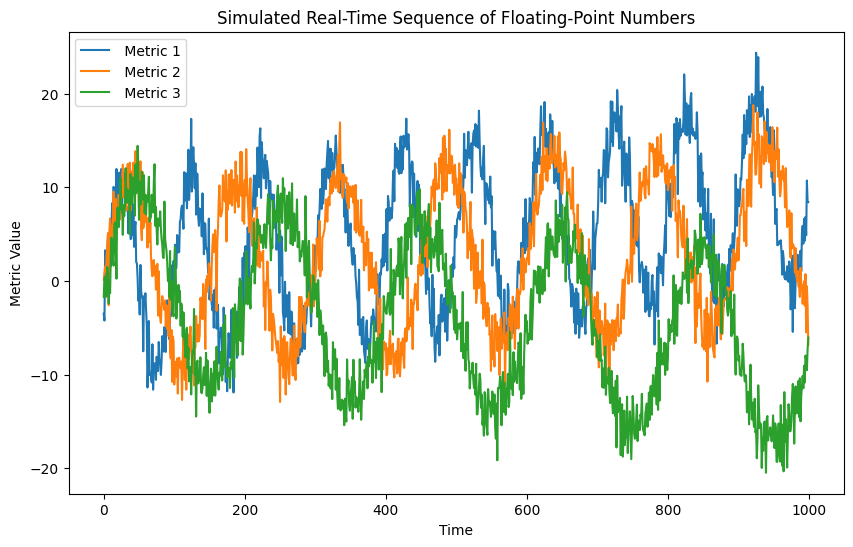

In [10]:
data_stream = simulate_data_stream()

plt.figure(figsize=(10,6))
plt.plot(data_stream['timestamp'], data_stream['metric_1'], label=' Metric 1')
plt.plot(data_stream['timestamp'], data_stream['metric_2'], label=' Metric 2')
plt.plot(data_stream['timestamp'], data_stream['metric_3'], label=' Metric 3')
plt.title('Simulated Real-Time Sequence of Floating-Point Numbers')
plt.xlabel('Time')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

## Anomaly Detection

### Z-Score

The **Z-Score** is a statistical measurement that represents the number of standard deviation a data point is from the mean of the data set. It is calculated as:

\[
Z = \frac{x - \mu}{\sigma}
\]

Where:
- \(x\) is the value of the data point,
- \(\mu\) is the mean of the dataset,
- \(\sigma\) is the standard deviation

Data points with a Z-Score that exceeds a threshold (commonly 3 or -3) are considered anomalies because they deviate significantly from the mean. **Z-score** is chosen for anomaly detection because it is simple and effective in detecting **point anomalies**, particularly in normally distributed data.

### Isolation Forest

**Isolation Forest** is an unsupervised machine learning algorithm designed specifically for anomaly detection. The algorithm works by building random decision trees, where anomalies are more likely to be isolated (separated from other points) in fewer steps compared to normal data points. The fewer steps required to isolate a point, the more likely it is to be an anomaly.

Key advantages of Isolation Forest:
- It is efficient and scalable, especially for high-dimensional data.
- It doesn't assume any specific data distribution, making it robust in various contexts.

Isolation Forest is chosen because it can detect **complex, multidimensional outliers** that may not be easily identified by statistical methods like Z-score. Combining it with Z-score allows for a **hybrid anomaly detection approach**, where both simple deviations and more complex patterns are detected in real time.

### Hybrid Approach

**Why Combine Z-score and Isolation Forest?**

The combination of **Z-score** and **Isolation Forest** offers a robust and comprehensive anomaly detection system:
- **Z-score** detects point anomalies based on statistical deviations.
- **Isolation Forest** detects anomalies by isolating outliers within the data structure.

This hybrid approach ensures that both basic and complex anomalies are detected, improving the accuracy of anomaly detection in the multivariate data stream.

### Function of Z-Score and Isolation Forest for Anomaly Detection

In [8]:
#function to validate data
def validate_data(data):
    if any(np.isnan(data)):
        raise ValueError("Data contains NaN values")
    if not all(isinstance(x, (int, float)) for x in data):
        raise ValueError("Data contains invalid types")
    if any(x < -1000 or x > 1000 for x in data):
        raise ValueError("Data contains values outside the expected range of 1000")

In [15]:
#function to calculate z-score anomalies
def zscore_anomaly(data, threshold=3):
    #calculate Z-scores for each metric
    z_scores = np.abs(zscore(data))
    #Flag anomalies where the z-score exceeds the threshold
    return z_scores > threshold

#function to simulate real-time anomaly detection using Z-score and Isolation Forest
def realtime_anomaly_detection_iforest(data_stream, zscore_threshold=3, contamination=0.05):
    #Initialize Isolation Forest
    isolation_forest = IsolationForest(random_state=42, contamination=contamination)

    #Store the result of anomaly flags
    anomalies = []

    #Fit the isolation forest model on the entire dataset (batch approach)
    iforest_preds = isolation_forest.fit_predict(data_stream[['metric_1', 'metric_2', 'metric_3']])

    #Process the data stream in real-time
    for i, row in data_stream.iterrows():
        #Extract current data point for each metric
        metric_1, metric_2, metric_3 = row['metric_1'], row['metric_2'], row['metric_3']

        #Z-score based anomaly detection
        current_data = np.array([metric_1, metric_2, metric_3])
        z_anomalies = zscore_anomaly(current_data, zscore_threshold)

        #Isolation Forest anomaly detection
        isolation_forest_anomaly = iforest_preds[i] == -1

        #Combine the results: Z-score anomalies and Isolation Forest
        combined_anomaly = z_anomalies.any() or isolation_forest_anomaly

        #Store the anomaly status for each timestamp
        anomalies.append({
            'timestamp': row['timestamp'],
            'metric_1_anomaly': z_anomalies[0],
            'metric_2_anomaly': z_anomalies[1],
            'metric_3_anomaly': z_anomalies[2],
            'isolation_forest_anomaly': isolation_forest_anomaly,
            'combined_anomaly': combined_anomaly
        })

        #Handle errors and unseen data
        try:
            validate_data([metric_1, metric_2, metric_3])
        except ValueError as e:
            print(f"Data validation error at timestamp {row['timestamp']}:{e}")

    return pd.DataFrame(anomalies)

### Visualization

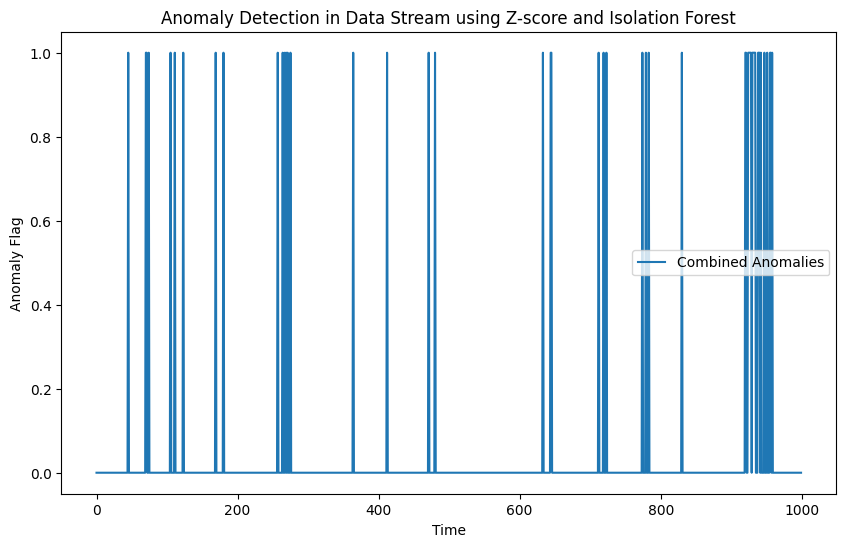

In [16]:
#Perform real-time anomaly detection using Z-Score and Isolation Forest
anomaly_results = realtime_anomaly_detection_iforest(simulate_data_stream(num_points=1000))

#Show combined anomalies over time
plt.figure(figsize=(10,6))
plt.plot(anomaly_results['timestamp'], anomaly_results['combined_anomaly'], label="Combined Anomalies")
plt.title("Anomaly Detection in Data Stream using Z-score and Isolation Forest")
plt.xlabel("Time")
plt.ylabel('Anomaly Flag')
plt.legend()
plt.show()